In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 02:  Descriptives
 * Name and franchise code (non independent observations)
 * Bank
 * Correlations

I do not do extensive data exploration but instead use others' insights from various
Kaggle projects, especially:
* https://www.kaggle.com/code/ricardocolindres/loan-default-prediction-loan-parameter-optimizer

I am also not going to use all the features I could.  I want to focus on NAICS, and so I don't do a lot with bank, franchise, or geography.

*This script takes about 1 minute on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import re, importlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
from pathlib import Path

In [4]:
from sba_gnn.sba_gnn import sg_plot 
sg_plot.plot_defaults()

## Import Data

In [5]:
sba_loans = pd.concat([pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet')),
                       pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_test.parquet')),
                       pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_val.parquet'))],
                      keys=['train', 'test', 'val'])

In [6]:
sba_loans.shape

(869288, 49)

In [7]:
sba_loans.head()

LoanNr_ChkDgt                            Name  \
      index                                                  
train 152812    2119644006  INTERNATIONAL SECURITY & TRADI   
      776790    8241693004  THE GENIE CO OF FAIRVW PRK INC   
      714237    7452154008           HOOKSET FIREWORKS INC   
      559037    5511925001          Drill Pro Services Inc   
      82973     1622844010                    CHINA CLOSET   

                                        City State    Zip  \
      index                                                 
train 152812                           MIAMI    FL  33172   
      776790               BROADVIEW HEIGHTS    OH  44147   
      714237  HOOKSETT (CENSUS NAME FOR HOOK    NH   3106   
      559037                       Williston    ND  58801   
      82973                   VESTAVIA HILLS    AL  35216   

                                        Bank BankState   NAICS ApprovalDate  \
      index                                                                   
train 152812         FLORIDA BUS. DEVEL CORP        FL  421690   1998-06-09   
      776790            GROWTH CAPITAL CORP.        OH    None   1995-04-07   
      714237        CITIZENS BANK NATL ASSOC        NH  453998   2004-05-19   
      559037  FIRST NATL BK & TR CO OF WILLI        ND  238910   2012-10-24   
      82973                    PINNACLE BANK        AL  453220   1997-10-17   

              ApprovalFY  ...  NS___Accommodation and Food Services  \
      index               ...                                         
train 152812        1998  ...                                   0.0   
      776790        1995  ...                                   0.0   
      714237        2004  ...                                   0.0   
      559037        2013  ...                                   0.0   
      82973         1998  ...                                   0.0   

              NS___Construction NS___Health Care and Social Assistance  \
      index                                                              
train 152812                0.0                                    0.0   
      776790                0.0                                    0.0   
      714237                0.0                                    0.0   
      559037                1.0                                    0.0   
      82973                 0.0                                    0.0   

              NS___Manufacturing  \
      index                        
train 152812                 0.0   
      776790                 0.0   
      714237                 0.0   
      559037                 0.0   
      82973                  0.0   

              NS___Other Services (except Public Administration)  \
      index                                                        
train 152812                                                0.0    
      776790                                                0.0    
      714237                                                0.0    
      559037                                                0.0    
      82973                                                 0.0    

             NS___Professional, Scientific, and Technical Services  \
      index                                                          
train 152812                                                0.0      
      776790                                                0.0      
      714237                                                0.0      
      559037                                                0.0      
      82973                                                 0.0      

             NS___Retail Trade  NS___Wholesale Trade  NS___nan  \
      index                                                      
train 152812               0.0                   1.0       0.0   
      776790               0.0                   0.0       1.0   
      714237               1.0                   0.0       0.0   
      559037               0

In [8]:
train_df = sba_loans[sba_loans.index.get_level_values(0) == 'train'].copy().reset_index(drop=True)

In [9]:
train_df.shape

(565037, 49)

##### NAICS descriptions

In [114]:
naics_desc = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_naics07_descriptions.parquet')) \
    .drop_duplicates('NAICS07')

## Name and Franchise
These features are important to me because they may indicate non-independent observations.  There may be multiple loans for the same business.  Or, we may have multiple branches of a franchise who are not independent

For this project I am not likely to do anything to account for potential leakage or distortions due to non-independence.  This may be something a GNN will be helpful for and I may explore that in the future

I am not even going to do my train/test split by name or franchise, which would normally be the minimum I'd do with non-independent observations

##### Name - are there repeat loans?

In [10]:
print(sba_loans.shape)
print(sba_loans.drop_duplicates(['Name']).shape)
print(sba_loans.drop_duplicates(['Name', 'Zip', 'City', 'State']).shape)

(869288, 49)
(754175, 49)
(809947, 49)


In [11]:
# It looks like most repeat names are multi-locations (same name different address(  
# There are a few same name/location cases, probably the same business getting multiple loans.

In [12]:
sba_loans['Name'].value_counts().head(5)

Name
SUBWAY                 1267
QUIZNO'S SUBS           433
COLD STONE CREAMERY     366
QUIZNO'S                345
THE UPS STORE           323
Name: count, dtype: int64

In [13]:
# It appears that large franchises are getting many loans

In [14]:
sba_loans.groupby(['Name', 'Zip', 'City', 'State'])['franchise_flag'] \
    .agg(['count', 'mean']) \
    .sort_values('count', ascending=False) \
    .head()

,,,,count,mean
Name,Zip,City,State,,
WEST TEXAS LEE CO INC,79329,IDALOU,TX,131,0.0
WEST TEXAS LEE COMPANY INC,79329,IDALOU,TX,26,0.0
ECKERT DRILLING & CONSTRUCTION,15235,PITTSBURGH,PA,26,0.0
"ERIE PETROLEUM, INC.",16512,ERIE,PA,25,0.0
"J. B. DECK, CORP.",52640,MORNING SUN,IA,24,0.0


In [15]:
# There are some non-franchises getting tons of loans also

## Banks
I won't do anything with bank for this project, but it could also be an interesting GNN application in the future

##### Bank - loans per bank and histogram

In [16]:
sba_loans['Bank'].value_counts(dropna=False).head()

Bank
BANK OF AMERICA NATL ASSOC        85077
WELLS FARGO BANK NATL ASSOC       61078
JPMORGAN CHASE BANK NATL ASSOC    47368
U.S. BANK NATIONAL ASSOCIATION    33831
CITIZENS BANK NATL ASSOC          33688
Name: count, dtype: int64

In [17]:
sba_loans['Bank'].value_counts(dropna=False).shape

(5457,)

In [18]:
sba_count = sba_loans.groupby('Bank')['LoanNr_ChkDgt']\
    .agg(['count'])

In [19]:
sba_count.describe()
# Most banks are small.  There are a few mega-banks.  

,count
count,5456.000000
mean,159.136913
std,1846.570919
min,1.000000
25%,3.000000
50%,10.000000
75%,40.000000
max,85077.000000


## Correlations
Get correlations for all predictor features, as well as Term, the target indicator

##### Calculate Spearman correlations

In [20]:
# Correlations matrix
cor_df = train_df[['Term', 'target', 'menc_NAICS', 'menc_NAICS_sector'] + setup.predictor_features].corr(method='spearman')

In [21]:
cor_df.to_csv(Path(setup.temp_path).joinpath('02_REPORT_correlations.csv'), index=True)

##### Function to examine correlations for a given feature

In [22]:
def feat_corr(corr_data, feature='target',
             outpath = None,
             outfile_prefix = '02_PLOT_cor_'):
    feat_corr = corr_data[feature].rename('corr').reset_index()
    feat_corr['corr_abs'] = np.abs(feat_corr['corr'])
    feat_corr = feat_corr[feat_corr['index'] != feature]
    feat_corr.sort_values('corr_abs', ascending=False, inplace=True)
    
    fig = sg_plot.plot_basic_bar(feat_corr, label='index', y='corr')
    
    if outpath is not None:
        fig.savefig(Path(outpath).joinpath(outfile_prefix + feature))
        
    #print(fig)
              
    return feat_corr

##### Target correlations

,index,corr,corr_abs
0,Term,-0.420028,0.420028
2,menc_NAICS,0.272107,0.272107
3,menc_NAICS_sector,0.179992,0.179992
7,DisbursementGross,-0.163587,0.163587
4,NoEmp,-0.122138,0.122138
6,LowDoc,-0.082861,0.082861
5,CreateJob,0.064378,0.064378
9,urban_flag,0.051498,0.051498
8,new_business,0.017554,0.017554
10,franchise_flag,-0.016149,0.016149


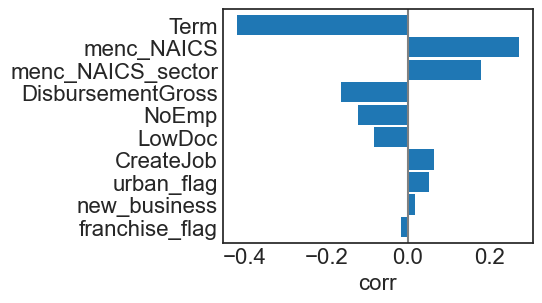

In [23]:
feat_corr(cor_df, 'target', outpath = Path(setup.temp_path))

The target feature is highly correlated with term (in Kaggle notebooks, models have very high performance, and I also see very high performance with this feature).  I think this feature is likely set by the creditworthiness of the businesses, as it is such a strong predictor

After term, NAICS seems to be the most significant feature.  Let's look at the NAICS feature now

##### NAICS correlations

,index,corr,corr_abs
3,menc_NAICS_sector,0.682715,0.682715
1,target,0.272107,0.272107
0,Term,-0.271637,0.271637
7,DisbursementGross,-0.264896,0.264896
4,NoEmp,-0.183396,0.183396
5,CreateJob,0.163027,0.163027
6,LowDoc,-0.151060,0.151060
9,urban_flag,0.046836,0.046836
8,new_business,0.015609,0.015609
10,franchise_flag,-0.002019,0.002019


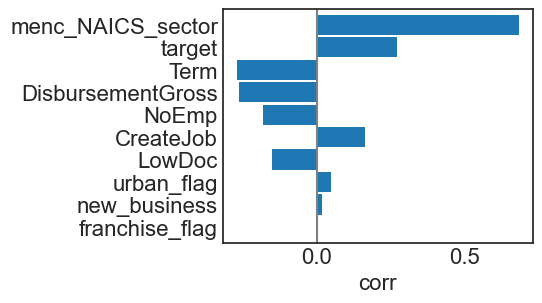

In [24]:
feat_corr(cor_df, 'menc_NAICS', outpath = Path(setup.temp_path))

The strong correlation with menc_NAICS_sector is to be expected. In addition to that, there are strong correlations with RevLineCr, RetainedJob, and other features. 

##### NAICS sector correlations

,index,corr,corr_abs
2,menc_NAICS,0.682715,0.682715
0,Term,-0.192333,0.192333
1,target,0.179992,0.179992
7,DisbursementGross,-0.177320,0.177320
4,NoEmp,-0.144681,0.144681
6,LowDoc,-0.125538,0.125538
5,CreateJob,0.117688,0.117688
10,franchise_flag,-0.020245,0.020245
8,new_business,-0.018871,0.018871
9,urban_flag,-0.007902,0.007902


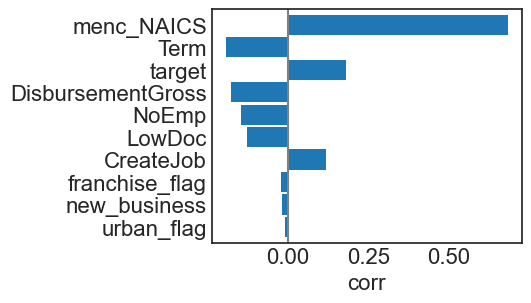

In [25]:
feat_corr(cor_df, 'menc_NAICS_sector', outpath = Path(setup.temp_path))

The overall pattern is similar to the full NAICS, but a bit weaker.

## Term
This feature is highly predictive and its use makes an excellent model.  I will probably drop it as it's probably set in proportion to creditworthiness.  Using this feature would make sense if you want to evaluate how well SBA is assigning risk, or to predict defaults given known risk.  But here I omit it because it makes a model so good NAICS doesn't matter.  Also removing this feature means predicting risk without the (implicit) benefit of the credit-worthiness assigned by the SBA.

I am going to explore how term is related to the target a little

##### Quartile stats

In [26]:
train_df['term_cat'] = pd.qcut(train_df['Term'], q=4)

In [27]:
train_df.groupby('term_cat') \
    .agg({'Term': 'mean', 'LoanNr_ChkDgt':'count',
          'target':'mean'})

,Term,LoanNr_ChkDgt,target
term_cat,,,
"(-0.001, 60.0]",41.301317,169652,0.381805
"(60.0, 84.0]",81.248699,185767,0.104297
"(84.0, 120.0]",111.338620,79068,0.104012
"(120.0, 569.0]",237.010777,130550,0.038116


There is a steady decrease in risk as term increases.  I wonder if enough time has passed to evaluate very long loans

##### Value counts, describe

In [28]:
train_df['Term'].value_counts().head(10)

Term
84     146715
60      57272
240     51831
120     48703
300     27387
180     16645
36      12774
12      10801
48      10101
72       5942
Name: count, dtype: int64

5 or 7 year terms are common!

In [29]:
train_df['Term'].describe()

count    565037.000000
mean        109.453464
std          78.196375
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         569.000000
Name: Term, dtype: float64

## NAICS
What is the variation of term rates within vs. between sectors?

In [120]:
importlib.reload(sg_plot)

<module 'sba_gnn.sba_gnn.sg_plot' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_plot.py'>

In [115]:
# Summarize target rates and counts by NAICS
naics_info = sg_plot.naics_variance_data(train_df)
naics_info = naics_info.merge(naics_desc.rename(columns={'NAICS07':'NAICS'}),
                             how='left', on='NAICS')
naics_info.to_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_counts_rates.csv'), index=False)

In [116]:
naics_info.head(5)

,NAICS,target,count,NAICS_sector,count_cat,target_cat,NAICS_sector_desc,target_sd,target_cat_sd,NAICS07_desc
0,445310,0.116142,4417,44-45,81588,0.228612,Retail Trade,0.005128,0.001674,"Beer stores, packaged"
1,447110,0.172548,4364,44-45,81588,0.228612,Retail Trade,0.006288,0.001674,Convenience food with gasoline stations
2,451110,0.190551,3810,44-45,81588,0.228612,Retail Trade,0.007072,0.001674,Athletic equipment and supply stores (includin...
3,453220,0.227357,3787,44-45,81588,0.228612,Retail Trade,0.007748,0.001674,Balloon shops
4,453998,0.313315,3680,44-45,81588,0.228612,Retail Trade,0.009227,0.001674,Art supply stores


In [ ]:
# Join in NAICS code descriptions

In [117]:
print(naics_info.shape)
print(naics_info[naics_info['count'] > 100].shape)

(1300, 10)
(589, 10)


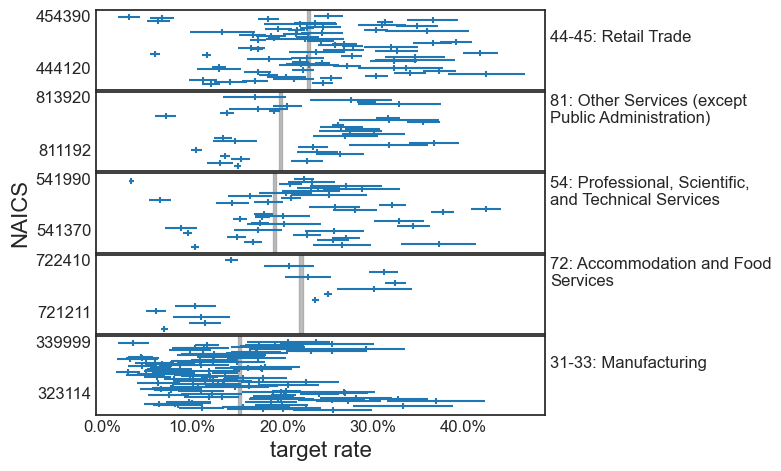

In [121]:
# Plot higher volume NAICS
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count'] > 100], num_sectors=5)
fig.savefig(Path(setup.temp_path).joinpath('02_PLOT_naics_counts_rates.png'),
           bbox_inches='tight')

In [119]:
# Export high-volume data for analysis
naics_info[naics_info['count'] > 100] \
           .sort_values(['target_cat', 'target'], ascending=[False, False]) \
           .to_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_counts_rates_high_vol.csv'), 
                   index=False)